# Tips for using `BGLS`

The `bgls.Simulator` is designed to be flexible and fast out of the box, automatically implementing optimizations such as:

- Parallel sampling: When applicable, all bitstrings are updated via one wavefunction evolution.
- Gate skipping: Bitstrings are not resampled for diagonal gates since these do not change the probability distribution.

On top of this, there are a few additional steps users can take to improve performance, described below.

In [1]:
"""Setup."""
import time

import cirq
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import bgls

## Optimizing circuits

### TL;DR

Call `bgls.optimize_for_bgls` to merge circuit operations and improve the runtime of the `BGLS` algorithm.

In [2]:
"""TL;DR example."""
# Example circuit.
circuit = cirq.testing.random_circuit(qubits=8, n_moments=12, op_density=1)

# Optimize the circuit before passing to the bgls.Simulator to improve performance.
optimized_circuit = bgls.optimize_for_bgls(circuit)

### Explanation

Consider the following Bell state circuit.

In [3]:
"""Create a Bell state circuit."""
a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.H.on(a), cirq.CNOT.on(a, b))
circuit

0: ───H───@───
          │
1: ───────X───

In the `BGLS` algorithm, the first bit gets updated upon application of the Hadamard gate, and then updated *again* upon application of the CNOT. In total, two probabilities need to be computed for the Hadamard, then four probabilities need to be computed for the CNOT, totaling six probabilities.

Consider instead an equivalent circuit with one two-qubit gate equal to the action of Hadamard then CNOT. (In other words, the product of the two gates.) In this case, only four probablities need to be computed instead of six.

This equivalent circuit can be found by calling `bgls.optimize_for_bgls`.

In [4]:
"""Optimizing the Bell state circuit."""
optimized_circuit = bgls.optimize_for_bgls(circuit)
optimized_circuit

┌                                           ┐
      │ 0.707+0.j  0.   +0.j  0.707+0.j  0.   +0.j│
0: ───│ 0.   +0.j  0.707+0.j  0.   +0.j  0.707+0.j│───
      │-0.   +0.j  0.707+0.j -0.   +0.j -0.707+0.j│
      │ 0.707+0.j -0.   +0.j -0.707+0.j -0.   +0.j│
      └                                           ┘
      │
1: ───#2──────────────────────────────────────────────

In general, `bgls.optimize_for_bgls` will merge all `k`-qubit operations where `k` is the max support of a unitary operation, as well as apply other optimizations such as dropping near-identity gates. As in the above example, the optimized circuit will typically contain operations specified by matrices - as long as your `apply_operation` function used in the `bgls.Simulator` supports this, you should see improved runtime by using optimized circuits. The amount of improvement can vary depending on the circuit structure, but performance should never decrease.

### Timing test

The following example benchmarks simulating random circuits before and after optimization.

In [5]:
nqubits = 8
depths = np.linspace(5, 50, 5, dtype=int)
repetitions = 1000
trials = 4

qubits = cirq.LineQubit.range(nqubits)

simulator = bgls.Simulator(
    initial_state=cirq.StateVectorSimulationState(qubits=qubits, initial_state=0),
    apply_gate=cirq.protocols.act_on,
    compute_probability=bgls.utils.cirq_state_vector_bitstring_probability,
)

all_times = []
all_times_with_merged_ops = []

for t in tqdm(range(trials), desc="Trial"):
    times = []
    times_with_merged_ops = []

    for depth in depths:
        circuit = cirq.testing.random_circuit(qubits, depth, 1) + cirq.measure(qubits)
        circuit_optimized = bgls.optimize_for_bgls(circuit)

        start = time.monotonic()
        _ = simulator.run(circuit, repetitions=repetitions)
        times.append(time.monotonic() - start)

        start = time.monotonic()
        _ = simulator.run(circuit_optimized, repetitions=repetitions)
        times_with_merged_ops.append(time.monotonic() - start)
    
    all_times.append(times)
    all_times_with_merged_ops.append(times_with_merged_ops)

Trial: 100%|██████████| 4/4 [00:31<00:00,  7.89s/it]


We can plot the runtimes to see the value of `bgls.optimize_for_bgls` in this case.

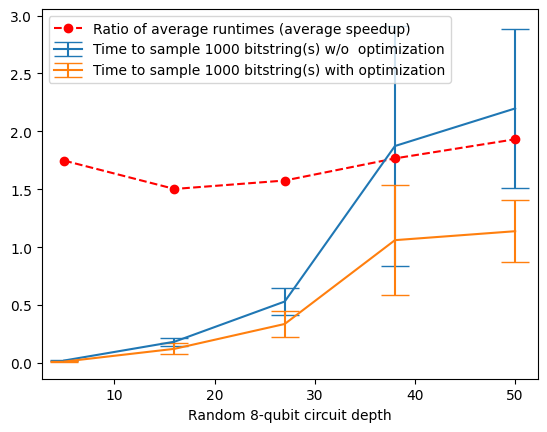

In [6]:
times = np.average(all_times, axis=0)
times_with_merged_ops = np.average(all_times_with_merged_ops, axis=0)

times_std = np.std(all_times, axis=0, ddof=1)
times_with_merged_ops_std = np.std(all_times_with_merged_ops, axis=0, ddof=1)

plt.errorbar(depths, times, yerr=times_std, capsize=10, label=f"Time to sample {repetitions} bitstring(s) w/o  optimization")
plt.errorbar(depths, times_with_merged_ops, yerr=times_with_merged_ops_std, capsize=10, label=f"Time to sample {repetitions} bitstring(s) with optimization")
plt.plot(depths, times / times_with_merged_ops, "--o", label="Ratio of average runtimes (average speedup)", color="red")
plt.xlabel(f"Random {nqubits}-qubit circuit depth")
plt.legend()

plt.show();

Here, we see between a 1.5x speedup and 2x speedup obtained by calling `bgls.optimize_for_bgls`.